## generic value iteration algo 

In [37]:
import numpy as np 
from typing import Callable

## SPECIALISED FOR EX 9.27

In [3]:
def Value_iteration(S:list[tuple], # states
                    A:tuple,       # actions
                    P:list,        # probabilities
                    R:list,         # rewards
                    cutoff:int = 1000, 
                    discount_rate:float=0.8):
    # we assign V0[s] arbitrarily to start with
    V0 = np.zeros(2) #np.random.rand(len(S))  # Ensures values are float
    V_k = V0.astype(float)  
    k = 0
    pi = [0,0]
    while k < cutoff:
        V_k_minus_1 = V_k
        for index, state in enumerate(S):
            possible_values = [R[index][a] + discount_rate * (P[index][a]*V_k_minus_1[0] + (1-P[index][a])*V_k_minus_1[1]) for a in range(len(A))]
            V_k[index] = max(possible_values).astype(float)
        k += 1

    for index, state in enumerate(S):
        possible_values =  [R[index][a] + discount_rate * (P[index][a]*V_k_minus_1[0] + (1-P[index][a])*V_k_minus_1[1]) for a in range(len(A))]
        pi[index] =  possible_values.index(max(possible_values))

    return V_k, pi


###############################################
############# FUNCTION CALL ###################
###############################################

States = ('healthy', 'sick')
Actions = ('Relax', 'Party')
# we will be taking 0 to be healthy and 1 to be sick in terms of state
# and we will be using 0 for relax, and 1 to party 

Probabilities = [[0.95, # if healthy and relax
                 0.7],  # if healthy and party
                [ 0.5,  # if sick and relax
                 0.1]]  # if sick and party

Rewards = [[7, # if healthy and relax
            10],  # if healthy and party
            [0,  # if sick and relax
            2]]  # if sick and party

values, policies = Value_iteration(States, Actions, Probabilities, Rewards)

print('We determine the optimal policy to be:')
for index, value in enumerate(policies):
    print(f'if {States[index]}, then {Actions[value]}')

We determine the optimal policy to be:
if healthy, then Party
if sick, then Relax


## SPECIALISED FOR EX 9.28

In [26]:
def bellman_equation(actions, state, probabilities, V, rewards, discount_factor):
    values = []
    i, j = state  # coords
    corners = [(0, 0), (0, len(V) - 1), (len(V) - 1, 0), (len(V) - 1, len(V) - 1)]
    
    for intended_action in actions:
        # this inner for loop should be maximising over all intended actions to tell you which is the best
        summation_term = 0
        
        for possible_action in actions:
            probability_of_occurence = probabilities[0] if possible_action == intended_action else probabilities[1]
            
            # check where we are, and if this is within the grid
            new_i, new_j = i + possible_action[0], j + possible_action[1]
            
            if 0 <= new_i < len(V) and 0 <= new_j < len(V[0]):
                reward = rewards[i, j]  # Immediate reward 
                
                if reward != 0:  # if you are on a reward cell/ move into one, teleport to random corner
                    future_value = sum(V[corner] for corner in corners) / 4  
                else:
                    future_value = V[new_i, new_j]  # non special transition
            else:
                # stay in place and apply wall penalty if you hit wall 
                # print('this is triggered')
                reward = -1
                future_value = V[i, j]
            summation_term += probability_of_occurence * (reward + discount_factor * future_value)
        
        values.append(summation_term)  
    
    return max(values) # only return max value, not all of them 


In [66]:
def Value_iteration(S:np.ndarray, # states
                    A:tuple,       # actions
                    P:list,        # probabilities
                    R:list,         # rewards
                    cutoff:int = 1000, 
                    discount_rate:float=0.8):
    
    # we assign V0[s] arbitrarily to start with
    V0 = np.zeros(S.shape) 
    V_k = V0.astype(float)  
    k = 0
    pi = np.zeros(S.shape) 
    while k < cutoff:
        V_k_minus_1 = V_k.copy()
        
        for (i, j), value in np.ndenumerate(S):
            V_k[i][j] = bellman_equation(A, (i,j), P, V_k_minus_1, R, discount_rate)
        k += 1

    return np.round(V_k, decimals=1)

In [72]:
states = np.zeros((10, 10))

actions = [(1, 0),    # right
           (-1, 0),   # left
           (0, 1),    # up
           (0, -1)]   # down

probabilities = [0.7, 0.1]

rewards = np.zeros((10,10))
rewards[8][7] = 10
rewards[7][2] = 3
rewards[3][4] = -5
rewards[3][7] = -10

output = Value_iteration(S = states, 
                A = actions, 
                P = probabilities, 
                R = rewards, 
                cutoff=1000,
                discount_rate=0.9)

In [73]:
print(output.T)

[[ 0.9  1.4  1.7  2.   2.5  2.9  3.5  4.   3.6  3. ]
 [ 1.3  1.7  2.1  2.5  3.   3.6  4.2  4.9  4.3  3.7]
 [ 1.5  1.9  2.3  2.8  3.4  4.1  5.   6.   5.1  4.5]
 [ 1.4  1.8  2.1  2.4  3.4  4.1  4.8  5.6  6.   5.4]
 [ 1.4  1.8  1.8 -2.   3.5  4.6  5.5  6.4  7.2  6.5]
 [ 1.7  2.1  2.6  3.2  4.5  5.5  6.5  7.6  8.7  7.7]
 [ 1.6  2.1  2.5  3.1  5.1  6.4  7.6  9.  10.6  9.1]
 [ 1.5  1.8  1.4 -7.   4.7  7.   8.7 10.6 13.  10.7]
 [ 1.7  2.1  2.6  3.2  5.1  6.4  7.6  9.  10.6  9.1]
 [ 1.7  2.3  2.9  3.6  4.5  5.4  6.5  7.6  8.8  7.7]]


In [36]:
V0 = np.zeros(states.shape) 
V = V0.astype(float)  
discount_factor = 0.9
values = []
i, j = (8,7)

corners = [(0, 0), (0, len(V) - 1), (len(V) - 1, 0), (len(V) - 1, len(V) - 1)]

for intended_action in actions:
    # this inner for loop should be maximising over all intended actions to tell you which is the best
    summation_term = 0
    
    for possible_action in actions:
        probability_of_occurence = probabilities[0] if possible_action == intended_action else probabilities[1]
        
        # check where we are, and if this is within the grid
        new_i, new_j = i + possible_action[0], j + possible_action[1]
        
        if 0 <= new_i < len(V) and 0 <= new_j < len(V[0]):
            reward = rewards[i, j]  # Immediate reward 
            
            if reward != 0:  # if you are on a reward cell/ move into one, teleport to random corner
                future_value = sum(V[corner] for corner in corners) / 4  
            else:
                future_value = V[new_i, new_j]  # non special transition
        else:
            # stay in place and apply wall penalty if you hit wall 
            # print('this is triggered')
            reward = -1
            future_value = V[i, j]
        summation_term += probability_of_occurence * (reward + discount_factor * future_value)
    
    values.append(summation_term)  
    

In [1]:
len_x, len_y = 15, 10 

states = [(i, j) for i in range(len_x) for j in range(len_y)]
probabilities = {}

corners = [(0, 0), (0, len_y - 1), (len_x - 1, 0), (len_x - 1, len_y - 1)]
reward_states = [(8,7), (7,2), (3,4), (3,7), (13,4)]
reward_values = [10, 3, -5, -10, 10]

actions = [(1, 0),    # right
           (-1, 0),   # left
           (0, 1),    # up
           (0, -1)]   # down

## probabilities

In [2]:
def populate_probabilities_rewards(state, actions):
    sub_dirs = {}
    for index, _ in enumerate(actions):
        sub_dirs[index] = {}
        for corner in corners:
            sub_dirs[index][(corner)] = 0.25
    return sub_dirs

def populate_probabilities_usual(state, actions):
    sub_dirs = {}
    for index, intended_move in enumerate(actions):
        sub_dirs[index] = {}
        for actual_move in actions:
            value = 0.7 if intended_move == actual_move else 0.1
            sub_dirs[index][(state[0] + actual_move[0], state[1] + actual_move[1])] = value
    return sub_dirs

def populate_probabilities_edge(state, actions):
    sub_dirs = {}

    for index, intended_move in enumerate(actions):
        sub_dirs[index] = {}

        for actual_move in actions:
            new_row = state[0] + actual_move[0]
            new_col = state[1] + actual_move[1]

            # Check if out of bounds
            if (new_row < 0 or new_row >= len_y or
                new_col < 0 or new_col >= len_x):
                # Remain in the same cell 
                new_state = state
            else:
                new_state = (new_row, new_col)

            value = 0.7 if intended_move == actual_move else 0.1
            sub_dirs[index][new_state] = value

    return sub_dirs

In [3]:
for state in states:
    i, j = state
    if state in reward_states and reward_values[reward_states.index(state)] > 0:
        # teleportation step
        probabilities[state] = populate_probabilities_rewards(state, actions)
    elif 0 < i < len_x-1 and 0 < j < len_y-1:
        # we are in standard operating conditions, make usual sub directories
        probabilities[state] = populate_probabilities_usual(state, actions)
    else: # we must be at an edge
        probabilities[state] = populate_probabilities_edge(state, actions)

In [4]:
def populate_positive_rewards(state, actions, reward_value):
    sub_dirs = {}
    for index, _ in enumerate(actions):
        sub_dirs[index] = {}
        for corner in corners:
            sub_dirs[index][(corner)] = reward_value
    return sub_dirs

def populate_negative_rewards(state, actions, reward_value):
    sub_dirs = {}
    for index, intended_move in enumerate(actions):
        sub_dirs[index] = {}
        for actual_move in actions:
            sub_dirs[index][(state[0] + actual_move[0], state[1] + actual_move[1])] = reward_value
    return sub_dirs

def populate_edge_penalties(state, actions):
    sub_dirs = {}

    for index, intended_move in enumerate(actions):
        sub_dirs[index] = {}

        for actual_move in actions:
            new_row = state[0] + actual_move[0]
            new_col = state[1] + actual_move[1]

            # Check if out of bounds
            if (new_row < 0 or new_row >= len_y or
                new_col < 0 or new_col >= len_x):
                # Remain in the same cell 
                new_state = state
            else:
                new_state = (new_row, new_col)

            value = -1 if new_state == state else 0
            sub_dirs[index][new_state] = value

    return sub_dirs

In [5]:
rewards = {}
for state in states:
    i, j = state
    if state in reward_states and reward_values[reward_states.index(state)] > 0:
        # we are about to teleport
        rewards[state] = populate_positive_rewards(state, actions, reward_values[reward_states.index(state)])
    elif state in reward_states and reward_values[reward_states.index(state)] < 0:
        # we get a reward but do not teleport
        rewards[state] = populate_negative_rewards(state, actions, reward_values[reward_states.index(state)])
    elif i in [0, len_x-1] or j in [0, len_y-1]:
        rewards[state] = populate_edge_penalties(state, actions)

In [6]:
from MDP import GenericMDP
import numpy as np
mdp_solver = GenericMDP(states, actions, probabilities, rewards, 0.9, 200, len_x=15, len_y=10, reward_list=reward_states, reward_values= reward_values, problem_type='gridworld')

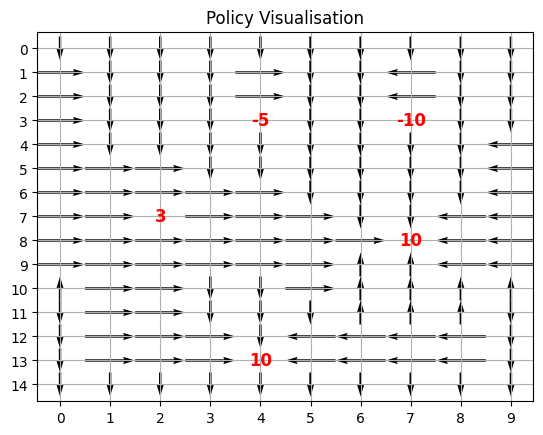

In [9]:
policy, values = mdp_solver()

In [10]:
array1 = np.zeros((len_x, len_y))
array2 = np.zeros((len_x, len_y))
for item in policy:
    array1[item[0], item[1]] = policy[item][0][0]
    array2[item[0], item[1]] = values[item]
np.set_printoptions(suppress=True, precision=3)
print('policy is:')
print(array1.T)
print('\n')
print('value function is:')
print(array2.T)

policy is:
[[0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
 [0. 0. 0. 0. 0. 2. 2. 0. 2. 2. 2. 2. 2. 2. 0.]
 [0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 0. 0. 2. 2. 0.]
 [0. 2. 2. 0. 0. 0. 2. 2. 2. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 0. 3. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 1. 1. 3. 3. 0.]
 [0. 3. 3. 0. 0. 0. 0. 0. 0. 1. 1. 1. 3. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3. 3. 3. 1. 1. 3. 3. 0.]
 [0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 1. 0. 0. 0. 0.]]


value function is:
[[ 0.507  0.781  0.992  1.218  1.477  1.771  2.066  2.274  2.595  2.411
   1.559 -0.11  -0.11  -0.11  -0.11 ]
 [ 0.772  1.072  1.306  1.565  1.865  2.21   2.565  2.778  3.238  3.27
   3.477  3.823  4.304  3.92  -0.11 ]
 [ 0.898  1.221  1.491  1.812  2.21   2.622  3.064  3.255  3.905  3.887
   4.282  4.973  5.742  5.639 -0.11 ]
 [ 0.872  1.154  1.355  1.611  2.523  3.093  3.658  4.235  4.715  4.534
   5.035  5.915  6.983  7.587 -0.11 ]
 [ 0.952  1.246  1.139 -2.932  2.559  3.619  4.3

In [10]:
dictionary = mdp_solver._value_iteration()
array = np.zeros((len_x, len_y))
for item in dictionary:
    array[item[0], item[1]] = dictionary[item]
np.set_printoptions(suppress=True, precision=3)
print(array.T)

[[ 0.902  1.282  1.594  1.937  2.334  2.793  3.314  3.791  3.424  2.724]
 [ 1.264  1.654  2.001  2.395  2.855  3.386  4.005  4.672  4.175  3.604]
 [ 1.409  1.823  2.217  2.693  3.284  3.943  4.732  5.706  4.955  4.378]
 [ 1.326  1.677  1.965  2.319  3.337  4.018  4.69   5.425  5.828  5.26 ]
 [ 1.375  1.726  1.704 -2.25   3.351  4.535  5.382  6.294  7.016  6.299]
 [ 1.612  2.06   2.499  3.074  4.401  5.351  6.325  7.444  8.505  7.504]
 [ 1.615  2.056  2.485  3.093  5.025  6.239  7.437  8.799 10.362  8.883]
 [ 1.439  1.77   1.414 -6.371  4.668  6.884  8.479 10.351 12.706 10.437]
 [ 1.648  2.109  2.546  3.138  5.023  6.229  7.429  8.791 10.352  8.815]
 [ 1.572  2.194  2.801  3.528  4.406  5.302  6.297  7.436  8.468  6.83 ]]


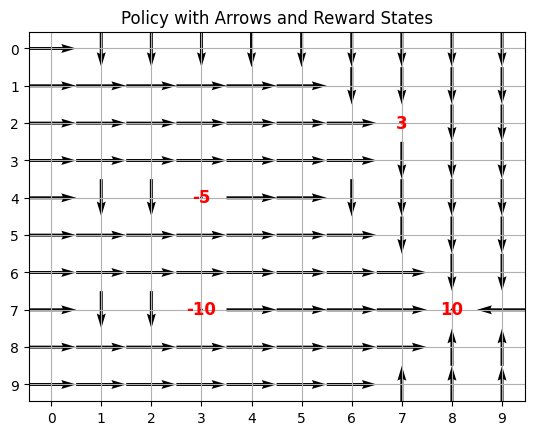

In [ ]:
import numpy as np
import matplotlib.pyplot as plt




# Direction mapping: [dx, dy] for each move (up, right, down, left)
arrow_map = {
    2: (1, 0),   # right
    3: (-1, 0),   # Left
    0: (0, -1),   # Up
    1: (0, 1),  # Down

}

rows, cols = array1.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

U = np.zeros_like(array1, dtype=float)
V = np.zeros_like(array1, dtype=float)

# Plot arrows or numbers
for i in range(rows):
    for j in range(cols):
        if (i, j) in reward_states:
            plt.text(i, j, f'{reward_values[reward_states.index((i, j))]}', ha='center', va='center', fontsize=12, fontweight='bold', color='red')
        else:
            dx, dy = arrow_map[int(array1[i, j])]
            U[i, j] = dx
            V[i, j] = -dy  

plt.quiver(Y, X, V, U, pivot='middle', scale=1, scale_units='xy', angles='xy')
plt.gca().invert_yaxis()
plt.xticks(np.arange(cols))
plt.yticks(np.arange(rows))
plt.grid(True)
plt.title("Policy Visualisation")
plt.show()


In [37]:
reward_states

[(8, 7), (7, 2), (3, 4), (3, 7)]

In [55]:
array1

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 2., 0., 0., 2., 0., 0.],
       [2., 0., 0., 0., 2., 0., 0., 2., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 2., 0., 0., 2., 0., 0., 0., 0., 0.],
       [2., 2., 0., 2., 2., 2., 0., 0., 0., 3.],
       [2., 2., 2., 2., 2., 2., 2., 0., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 1., 3., 3.]])